<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/parameter_estimation/parameter_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=6c887ddb82dd83af249ffbf7038109e083485faac4e1967d4e27848c77543445
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15096 sha256=8ca03f3a5d9d9bd8580d47f569676ecf68a58cde4de261a3df49d5da435dfd77
  Stored in directory: /root/.cache/pip/wheels/a8/92/ca/5bbab358275e310af23b73fc32ebf37d6a7a08c87c8d2cdbc1
Successfully built func-timeout


In [3]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd  
import sys
from scipy.integrate import odeint
from time import time as clock
import random

In [4]:
# In order to access the package you need to have its path. The path required is the path WHERE that package is soterd, not it path
# sys.path.insert(1, 'd:\\DYNAMICAL SIMULATION\\maestria\\maestria')

In [5]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 339 (delta 63), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (339/339), 9.56 MiB | 6.75 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [6]:
cd maestria

/content/maestria


In [7]:
import utilis.functions as fn
from utilis.models import monod_model, inhibition_model

In [8]:
# Definir parametros 
mu_max = 1.2 # g/L
yxs = 0.2 
ks = 280 # g/L
ypx = 4 
ki = 0.3 # L/g

# I need to move this functions later

In [9]:
def plot_simulated_data(data):
    plt.figure(figsize=(10, 5))
    plt.scatter(data.t, data.x, label = 'biomass')
    plt.scatter(data.t, data.s, label = 'substrate')
    plt.scatter(data.t, data.p, label = 'product')
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel('Concentration (g/L)', size = 20)
    plt.grid()
    plt.legend(fontsize=10)
    plt.show()

In [10]:
def fitness_function_monod(parms):
    mu_max, yxs, ks, ypx = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(monod_model, x0, time, args =(0, mu_max, yxs, ks, ypx,)).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_monod, out)

In [11]:
def fitness_function_inhibition(parms):
    mu_max, yxs, ks, ypx, ki = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(inhibition_model, x0, time, args =(0, mu_max, yxs, ks, ypx, ki, )).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_inhibition, out)

In [60]:
def calculate_stats(params):
    mean_values = np.mean(params, axis=0)
    std_values =  np.std(params, axis=0)
    stats = []
    for i in range(len(mean_values)):
        mean_value = mean_values[i]
        std_value = std_values[i]
        lower = mean_value - 2.57*std_value/np.sqrt(params.shape[0])
        upper = mean_value + 2.57*std_value/np.sqrt(params.shape[0])
        stats.append((mean_value, std_value, lower, upper))

    return stats

In [64]:
def plot_stats(data, real_value, y_label):
        
    mean = np.mean(data)
    confidence_interval = 2.57 * np.std(data) / np.sqrt(len(data))

    # Dibuja la gráfica
    plt.errorbar(1, mean, yerr=confidence_interval, fmt="o", color="red", label="Valor promedio")
    plt.scatter(np.full_like(data, 2), data, label = 'Estimado')
    plt.plot(3, real_value, "o", color="blue", label="Valor real")
    plt.xlim(0, 4)
    plt.xticks([1, 2, 3], ["Valor promedio","Estimado", "Valor real"], size = 10)
    plt.ylabel(y_label, size = 20)
    plt.legend()

# Load data

In [14]:
# Load data 
data_monod = pd.read_csv("data/data_monod.csv")
data_monod.head()

,t,x,s,p
0,0,0.242723,39.673568,0.320286
1,1,0.178948,39.776111,0.085047
2,2,0.325052,40.449577,0.366801
3,3,0.329567,40.093182,1.454305
4,4,0.425727,39.620962,1.313975


In [15]:
# Load data 
data_inhibition = pd.read_csv("data/data_inhibition.csv")
data_inhibition.head()

,t,x,s,p
0,0,0.174614,40.745821,1.081127
1,1,-0.060982,38.007323,-1.422682
2,2,0.087718,40.599858,-1.457520
3,3,0.242266,39.281919,0.688872
4,4,0.256444,40.626491,-0.866604


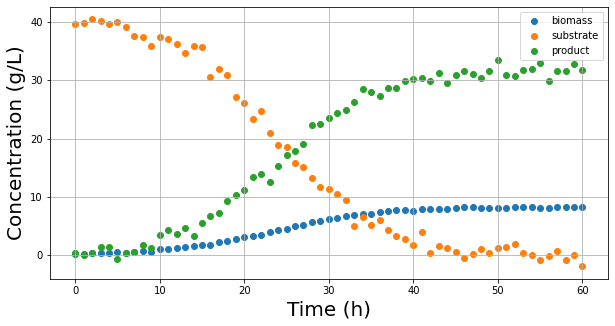

In [16]:
plot_simulated_data(data_monod)

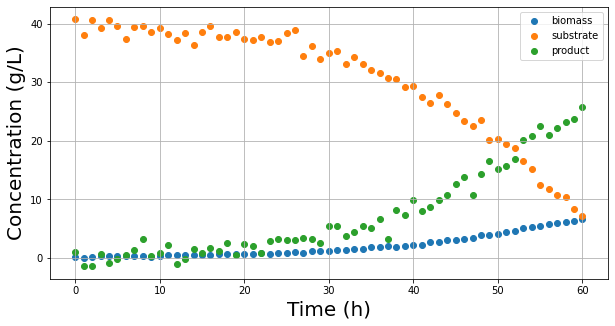

In [17]:
plot_simulated_data(data_inhibition)

# Valor de la funci{on fitness con valores corrector de los parámetros

In [18]:
fitness_function_monod([mu_max, yxs, ks, ypx])

1.8223412247601742

In [19]:
fitness_function_inhibition([mu_max, yxs, ks, ypx, ki])

2.221335566886478

# GA Configuration

In [73]:
# Configuramos algoritmo genetico
algorithm_param = {'max_num_iteration': 50,\
                   'population_size':50,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.8,\
                   'parents_portion': 0.5,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
runs = 5

# Monod

In [21]:
# Establecer los rangos de busqueda para las variables de decision
varbound_monod=np.array([
    [1,3], # mu_max
    [0.05,1], # yxs
    [200,300], # ks
    [1,10] # ypx
])

In [22]:
model_monod=ga(function=fitness_function_monod,
         dimension=4,
         variable_type='real',
         variable_boundaries=varbound_monod,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.15192671e+00 1.94781070e-01 2.71073795e+02 4.11733698e+00]

 Objective function:
 1.8321326144504793


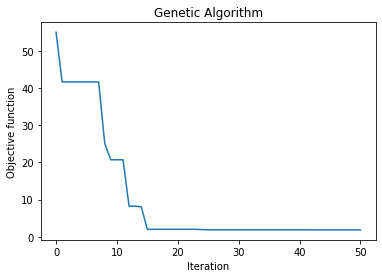

 The best solution found:
 [  1.02016663   0.24320003 220.78185466   3.20644575]

 Objective function:
 3.3741274423350753


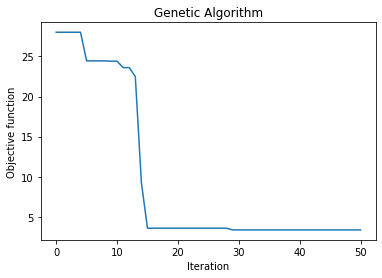

 The best solution found:
 [1.12796973e+00 1.60832954e-01 2.72546295e+02 4.67477553e+00]

 Objective function:
 4.8428828184782216


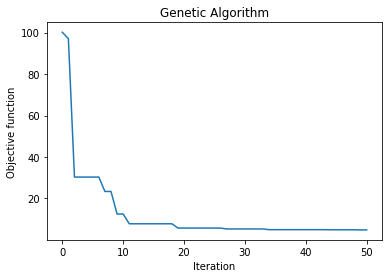

 The best solution found:
 [1.19113153e+00 1.96603881e-01 2.91261018e+02 4.05166371e+00]

 Objective function:
 2.4827499119678498


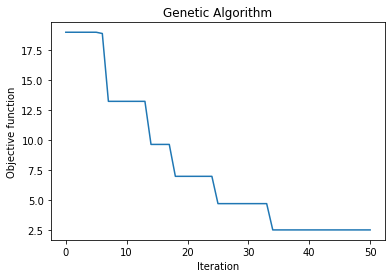

 The best solution found:
 [1.19341756e+00 1.71684844e-01 2.88001813e+02 4.51509145e+00]

 Objective function:
 3.0037767155385264


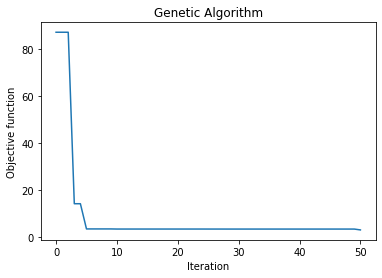

In [74]:

best_function_monod = []
best_values_monod = np.zeros((runs, varbound_monod.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(runs):
    model_monod.run()
    best_function_monod.append(model_monod.best_function)
    best_values_monod[i,:] = model_monod.best_variable
end_time = clock()

In [75]:
total_time = end_time - start_time
print(f"Total time: {total_time:.3f}s")

Total time: 16.269s


In [76]:
print("Minimun fitness value:")
for best_function in best_function_monod:
    print(best_function)

Minimun fitness value:
1.8321326144504793
3.3741274423350753
4.8428828184782216
2.4827499119678498
3.0037767155385264


In [77]:
print("Average minimum function value:", np.mean(best_function_monod))

Average minimum function value: 3.1071339005540306


In [78]:
print('Best solution found:')
for best_variables in best_values_monod: 
    print(best_variables)

Best solution found:
[1.15192671e+00 1.94781070e-01 2.71073795e+02 4.11733698e+00]
[  1.02016663   0.24320003 220.78185466   3.20644575]
[1.12796973e+00 1.60832954e-01 2.72546295e+02 4.67477553e+00]
[1.19113153e+00 1.96603881e-01 2.91261018e+02 4.05166371e+00]
[1.19341756e+00 1.71684844e-01 2.88001813e+02 4.51509145e+00]


In [79]:
stats_monod = calculate_stats(best_values_monod)

In [80]:
for stats in stats_monod:
    print(stats)

(1.1369224323265654, 0.06335222657194792, 1.0641092513641717, 1.2097356132889592)
(0.1934205562574019, 0.028370314602550642, 0.16081344893230182, 0.22602766358250198)
(268.73295505561487, 25.29083473686906, 239.66521385642784, 297.8006962548019)
(4.113062681329996, 0.5104685733366259, 3.5263612721259676, 4.699764090534025)


mu_max = 1.2  g/L

yxs = 0.2 

ks = 280  g/L

ypx = 4 

# Inhibition model

In [81]:
# Establecer los rangos de busqueda para las variables de decision
varbound_inhibition=np.array([
    [1,3], # mu_max
    [0.05,1], # yxs
    [200,300], # ks
    [1,10], # ypx
    [0.05,0.5] # ki
])

In [82]:
model_inhibition=ga(function=fitness_function_inhibition,
         dimension=5,
         variable_type='real',
         variable_boundaries=varbound_inhibition,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.22162084e+00 2.50323700e-01 2.76210605e+02 3.05776820e+00
 2.70222086e-01]

 Objective function:
 2.8649923615294326


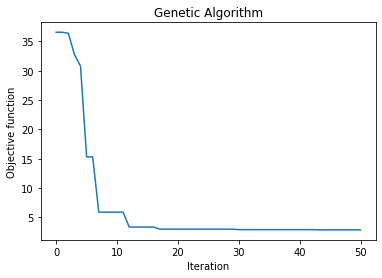

 The best solution found:
 [1.14330765e+00 1.76399140e-01 2.69930100e+02 4.52048058e+00
 3.03769725e-01]

 Objective function:
 2.3204072313134168


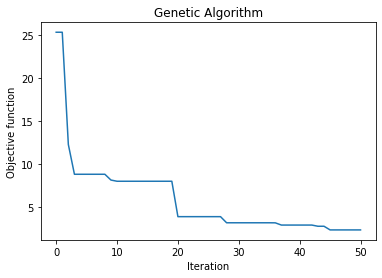

 The best solution found:
 [1.12340595e+00 2.12849899e-01 2.52911569e+02 3.57306378e+00
 2.74301218e-01]

 Objective function:
 2.3049677747405632


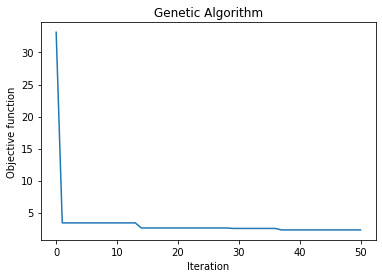

 The best solution found:
 [1.15845152e+00 2.09955512e-01 2.21468545e+02 3.38025658e+00
 3.09787920e-01]

 Objective function:
 3.3915237214909513


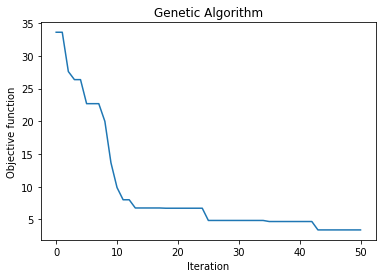

 The best solution found:
 [1.38611640e+00 1.58931822e-01 2.92559498e+02 4.83112633e+00
 4.28628629e-01]

 Objective function:
 2.4855544908331013


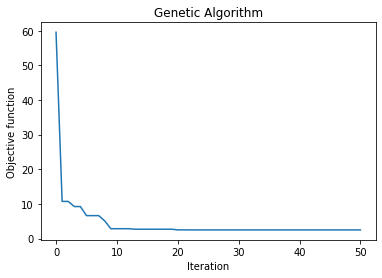

In [83]:
best_function_inhibition = []
best_values_inhibition = np.zeros((runs, varbound_inhibition.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(runs):
    model_inhibition.run()
    best_function_inhibition.append(model_inhibition.best_function)
    best_values_inhibition[i,:] = model_inhibition.best_variable
end_time = clock()

In [84]:
total_time_inhibition = end_time - start_time
print(f"Total time: {total_time_inhibition:.3f}s")

Total time: 16.689s


In [85]:
print("Minimun fitness value:")
for best_function in best_function_inhibition:
    print(best_function)

Minimun fitness value:
2.8649923615294326
2.3204072313134168
2.3049677747405632
3.3915237214909513
2.4855544908331013


In [86]:
print("Average minimum function value:", np.mean(best_function_inhibition))

Average minimum function value: 2.673489115981493


In [87]:
print('Best solution found:')
for best_variables in best_values_inhibition: 
    print(best_variables)

Best solution found:
[1.22162084e+00 2.50323700e-01 2.76210605e+02 3.05776820e+00
 2.70222086e-01]
[1.14330765e+00 1.76399140e-01 2.69930100e+02 4.52048058e+00
 3.03769725e-01]
[1.12340595e+00 2.12849899e-01 2.52911569e+02 3.57306378e+00
 2.74301218e-01]
[1.15845152e+00 2.09955512e-01 2.21468545e+02 3.38025658e+00
 3.09787920e-01]
[1.38611640e+00 1.58931822e-01 2.92559498e+02 4.83112633e+00
 4.28628629e-01]


In [88]:
stats_inhibition = calculate_stats(best_values_inhibition)

In [89]:
for stats in stats_inhibition:
    print(stats)

(1.2065804694789843, 0.0956004269779226, 1.0967031760310555, 1.3164577629269132)
(0.20169201448344393, 0.031704851837350397, 0.1652523936660584, 0.23813163530082945)
(262.61606341229316, 24.17524124292449, 234.83051725739244, 290.4016095671939)
(3.8725390945503464, 0.6833149810960757, 3.0871785781940946, 4.657899610906598)
(0.31734191525698857, 0.057790621702769426, 0.2509209033420539, 0.38376292717192323)


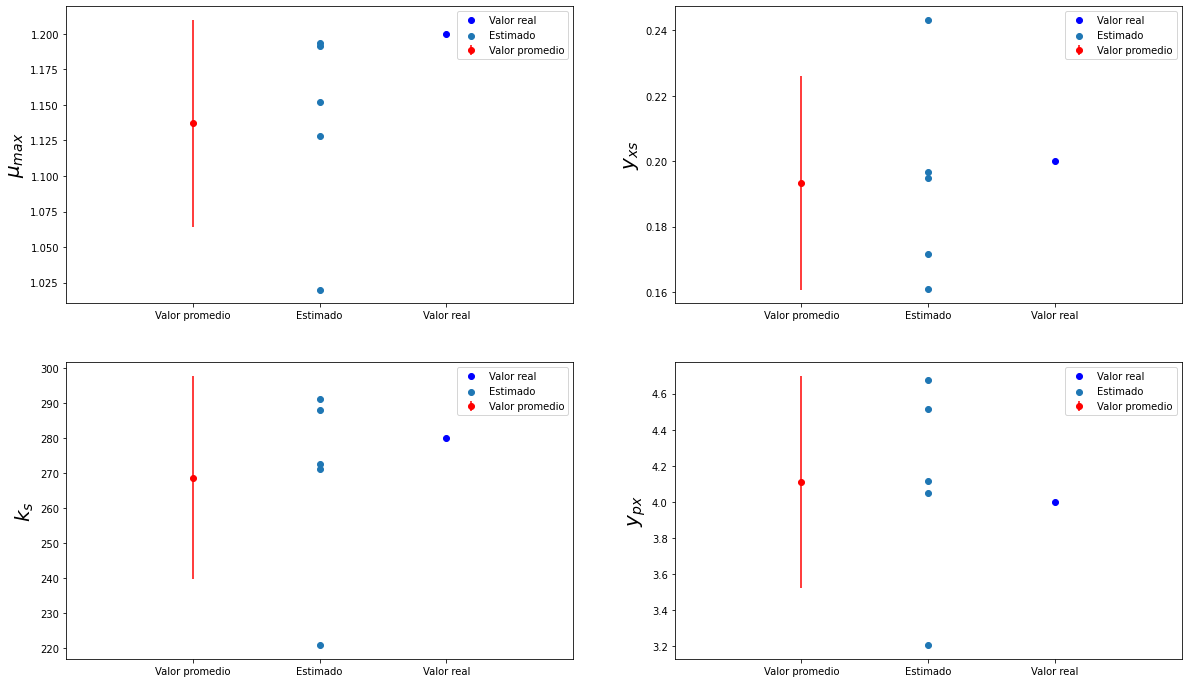

In [90]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_monod[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_monod[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_monod[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_monod[:, 3], ypx, "$y_{px}$")
plt.show()

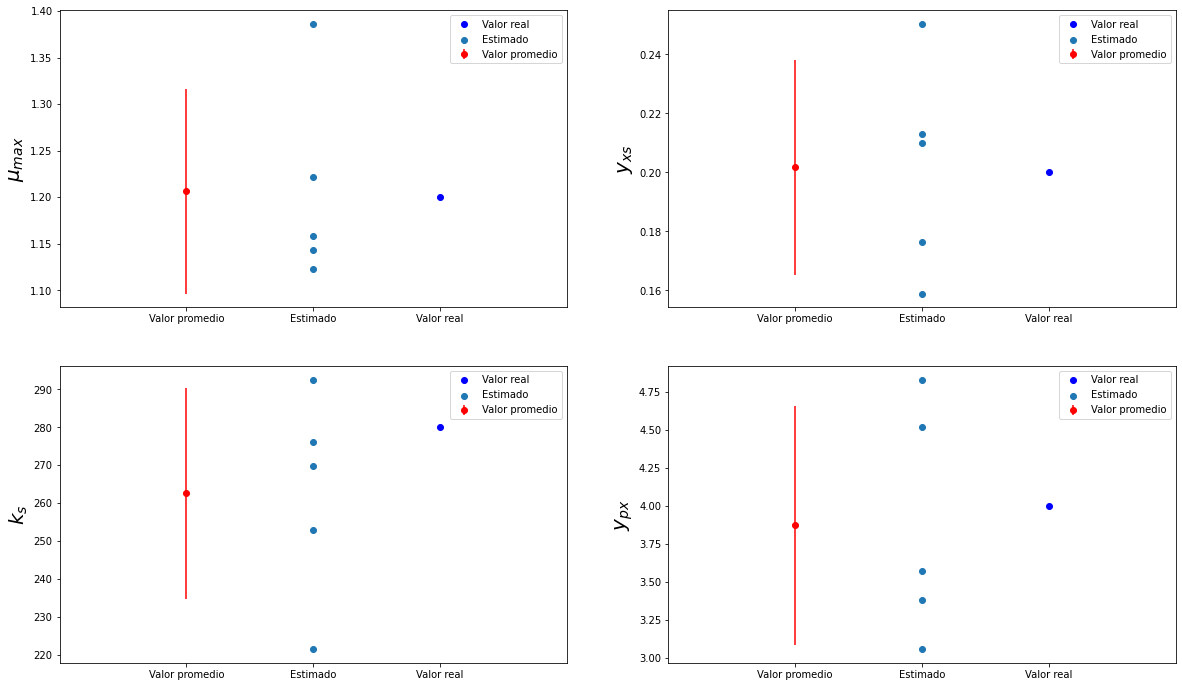

In [91]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_inhibition[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_inhibition[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_inhibition[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_inhibition[:, 3], ypx, "$y_{px}$")
plt.show()

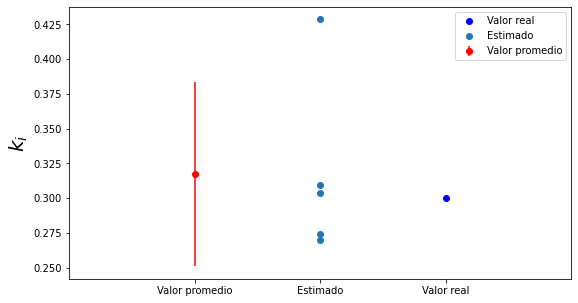

In [92]:
plt.figure(figsize=(9,5))
plot_stats(best_values_inhibition[:, 4], ki, "$k_i$")
plt.show()